In [3]:
# Model de Predicció d'Enfrontaments - La Liga 2023-2024
print("🚀 Iniciant Model de Predicció d'Enfrontaments...")
print("=" * 60)

# Importació de llibreries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuració
plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

print("✅ Llibreries importades correctament")

🚀 Iniciant Model de Predicció d'Enfrontaments...
✅ Llibreries importades correctament


In [4]:
print("Carregant dades...")

# Carregament de dades
df_classificacio = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-2023-2024.xlsx', 
                                sheet_name='ClassificacióGeneral')

df_partits = pd.read_excel('BDD_EntrenamentModel_Estadístiques-La_Liga-2023-2024.xlsx', 
                           sheet_name='StatsPartit')

print(f"�� Dades de classificació: {df_classificacio.shape}")
print(f"⚽ Dades de partits: {df_partits.shape}")
print(f"Equips la Liga: {len(df_classificacio['Team'].unique())}")
print(f"Partits analitzats: {len(df_partits)}")


print("Equips temporada 2023-2024:")
for equip in df_classificacio['Team']:
    print(equip)
print('Dades llegides correctament')

Carregant dades...
�� Dades de classificació: (20, 27)
⚽ Dades de partits: (760, 33)
Equips la Liga: 20
Partits analitzats: 760
Equips temporada 2023-2024:
Real Madrid
Barcelona
Girona
Atlético Madrid
Athletic Club
Real Sociedad
Real Betis
Villarreal
Valencia
Alavés
Osasuna
Getafe
Celta Vigo
Sevilla
Mallorca
Las Palmas
Rayo Vallecano
Cádiz
Almería
Granada
Dades llegides correctament


ANÀLISI DE VARIABLES

�� Estadístiques dels partits:
- Mitjana de gols per partit: 2.64
- Mitjana de corners per partit: 4.7
- Mitjana de xuts per partit: 12.2
- Mitjana de possessió: 50.0%

🔗 CORRELACIONS PRINCIPALS

�� Top 5 correlacions amb gols marcats:
  1. Victory: 0.612
  2. shotsOnTarget: 0.322
  3. shotPct: 0.240
  4. penaltyKickGoals: 0.167
  5. penaltyKickShots: 0.142

�� Top 5 correlacions amb victòria local:
  1. Home Goal: 0.612
  2. shotsOnTarget: 0.081
  3. shotPct: 0.057
  4. penaltyKickShots: 0.056
  5. accuratePasses: 0.051


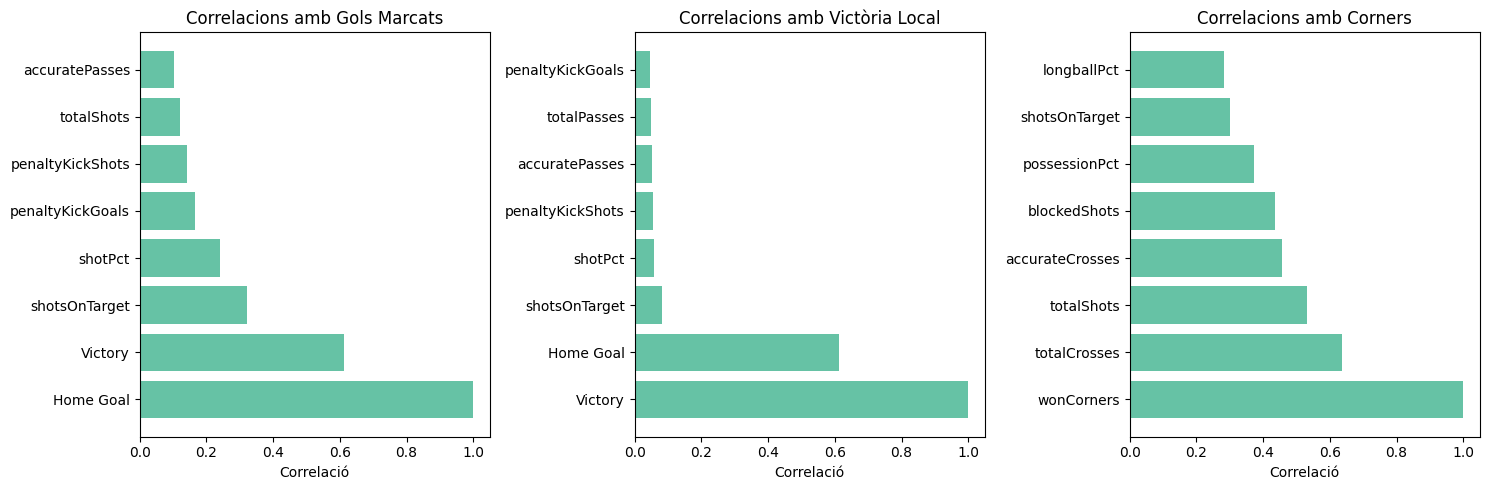

In [6]:
print("ANÀLISI DE VARIABLES")
print("=" * 50)

# Estadístiques bàsiques dels partits
print("\n�� Estadístiques dels partits:")
print(f"- Mitjana de gols per partit: {df_partits['Home Goal'].mean() + df_partits['Away Goal'].mean():.2f}")
print(f"- Mitjana de corners per partit: {df_partits['wonCorners'].mean():.1f}")
print(f"- Mitjana de xuts per partit: {df_partits['totalShots'].mean():.1f}")
print(f"- Mitjana de possessió: {df_partits['possessionPct'].mean():.1f}%")

# Anàlisi de correlacions
print("\n🔗 CORRELACIONS PRINCIPALS")
print("=" * 50)

# Seleccionem columnes numèriques
numeric_columns = df_partits.select_dtypes(include=[np.number]).columns

# Correlacions amb gols marcats
correlacions_gols = df_partits[numeric_columns].corr()['Home Goal'].sort_values(ascending=False)
print("\n�� Top 5 correlacions amb gols marcats:")
for i, (variable, correlacio) in enumerate(correlacions_gols.head(6).items()):
    if variable != 'Home Goal':
        print(f"  {i}. {variable}: {correlacio:.3f}")

# Correlacions amb victòria
df_partits['Victory'] = (df_partits['Home Goal'] > df_partits['Away Goal']).astype(int)
correlacions_victoria = df_partits[numeric_columns].corr()['Victory'].sort_values(ascending=False)
print("\n�� Top 5 correlacions amb victòria local:")
for i, (variable, correlacio) in enumerate(correlacions_victoria.head(6).items()):
    if variable != 'Victory':
        print(f"  {i}. {variable}: {correlacio:.3f}")

# Visualització de correlacions
plt.figure(figsize=(15, 5))

# Correlacions amb gols marcats
plt.subplot(1, 3, 1)
top_correlations_goals = correlacions_gols.head(8)
plt.barh(range(len(top_correlations_goals)), top_correlations_goals.values)
plt.yticks(range(len(top_correlations_goals)), top_correlations_goals.index)
plt.title('Correlacions amb Gols Marcats')
plt.xlabel('Correlació')

# Correlacions amb victòria
plt.subplot(1, 3, 2)
top_correlations_victory = correlacions_victoria.head(8)
plt.barh(range(len(top_correlations_victory)), top_correlations_victory.values)
plt.yticks(range(len(top_correlations_victory)), top_correlations_victory.index)
plt.title('Correlacions amb Victòria Local')
plt.xlabel('Correlació')

# Correlacions amb corners
plt.subplot(1, 3, 3)
correlacions_corners = df_partits[numeric_columns].corr()['wonCorners'].sort_values(ascending=False)
top_correlations_corners = correlacions_corners.head(8)
plt.barh(range(len(top_correlations_corners)), top_correlations_corners.values)
plt.yticks(range(len(top_correlations_corners)), top_correlations_corners.index)
plt.title('Correlacions amb Corners')
plt.xlabel('Correlació')

plt.tight_layout()
plt.show()

In [8]:
print("\n🔧 PREPARACIÓ DE DADES")
print("=" * 50)

# Funció per obtenir estadístiques d'un equip
def obtenir_stats_equip(equip_nom, df_classificacio):
    """Obtenim les estadístiques d'un equip específic"""
    if equip_nom in df_classificacio['Team'].values:
        return df_classificacio[df_classificacio['Team'] == equip_nom].iloc[0]
    else:
        # Si no trobem l'equip, retornem valors mitjans
        return df_classificacio.mean()

# Funció per crear features dels equips
def crear_features_equips(df_partits, df_classificacio):
    """Creem features combinant estadístiques dels equips amb dades de partits"""
    df_nou = df_partits.copy()
    
    # Columnes de classificació (excloent 'Team')
    stats_columns = [col for col in df_classificacio.columns if col != 'Team']
    
    # Afegim estadístiques de l'equip local
    for col in stats_columns:
        df_nou[f'Home_{col}'] = df_nou['Home Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    # Afegim estadístiques de l'equip visitant
    for col in stats_columns:
        df_nou[f'Away_{col}'] = df_nou['Away Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    return df_nou

print("�� Preparant dades...")

# Apliquem la funció
df_complet = crear_features_equips(df_partits, df_classificacio)

print(f"✅ Dataset complet creat: {df_complet.shape}")
print(f"📊 Features dels equips: {len([col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')])}")

# Creació de variables objectiu
print("\n🎯 Creant variables objectiu...")

# Variables objectiu
df_complet['Victory'] = (df_complet['Home Goal'] > df_complet['Away Goal']).astype(int)
df_complet['Draw'] = (df_complet['Home Goal'] == df_complet['Away Goal']).astype(int)
df_complet['Total_Goals'] = df_complet['Home Goal'] + df_complet['Away Goal']
df_complet['Goal_Difference'] = df_complet['Home Goal'] - df_complet['Away Goal']

# Resultat categòric
def crear_resultat_categoric(row):
    if row['Home Goal'] > row['Away Goal']:
        return 'Home_Win'
    elif row['Home Goal'] < row['Away Goal']:
        return 'Away_Win'
    else:
        return 'Draw'

df_complet['Result'] = df_complet.apply(crear_resultat_categoric, axis=1)

# Mostrem estadístiques
print("\n📈 Estadístiques de les variables objectiu:")
print(f"- Victòries locals: {df_complet['Victory'].sum()} ({df_complet['Victory'].mean():.1%})")
print(f"- Empats: {df_complet['Draw'].sum()} ({df_complet['Draw'].mean():.1%})")
print(f"- Gols totals (mitjana): {df_complet['Total_Goals'].mean():.2f}")
print(f"- Corners (mitjana): {df_complet['wonCorners'].mean():.1f}")

print("\n🏆 Distribució de resultats:")
for resultat, count in df_complet['Result'].value_counts().items():
    print(f"  {resultat}: {count} ({count/len(df_complet):.1%})")

# Selecció de features per al model
print("\n🔍 Seleccionant features...")

# Features del partit
features_partit = [
    'foulsCommitted', 'yellowCards', 'redCards', 'offsides', 'wonCorners',
    'saves', 'possessionPct', 'totalShots', 'shotsOnTarget', 'shotPct',
    'penaltyKickGoals', 'penaltyKickShots', 'accuratePasses', 'totalPasses',
    'passPct', 'accurateCrosses', 'totalCrosses', 'crossPct', 'accurateLongBalls',
    'totalLongBalls', 'longballPct', 'blockedShots', 'effectiveTackles',
    'totalTackles', 'tacklePct', 'interceptions', 'effectiveClearance', 'totalClearance'
]

# Features dels equips
features_equips = [col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')]

# Combinem totes les features
X_features = features_partit + features_equips

# Dataset final per al model
df_model = df_complet[X_features + ['Victory', 'Total_Goals', 'wonCorners', 'Result']].dropna()

X = df_model[X_features]
y_victory = df_model['Victory']
y_goals = df_model['Total_Goals']
y_corners = df_model['wonCorners']
y_result = df_model['Result']

print(f"✅ Dataset final: {df_model.shape}")
print(f"📊 Features utilitzades: {len(X_features)}")
print(f"�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat")


🔧 PREPARACIÓ DE DADES
�� Preparant dades...
✅ Dataset complet creat: (760, 86)
📊 Features dels equips: 52

🎯 Creant variables objectiu...

📈 Estadístiques de les variables objectiu:
- Victòries locals: 334 (43.9%)
- Empats: 214 (28.2%)
- Gols totals (mitjana): 2.64
- Corners (mitjana): 4.7

🏆 Distribució de resultats:
  Home_Win: 334 (43.9%)
  Draw: 214 (28.2%)
  Away_Win: 212 (27.9%)

🔍 Seleccionant features...
✅ Dataset final: (760, 84)
📊 Features utilitzades: 80
�� Variables objectiu: Victòria, Gols Totals, Corners, Resultat


In [9]:
print("\n�� ENTRENAMENT DE MODELS")
print("=" * 50)

# Divisió de dades
print("🔄 Dividint dades en entrenament i test...")

X_train, X_test, y_victory_train, y_victory_test = train_test_split(
    X, y_victory, test_size=0.2, random_state=42, stratify=y_victory
)

_, _, y_goals_train, y_goals_test = train_test_split(
    X, y_goals, test_size=0.2, random_state=42
)

_, _, y_corners_train, y_corners_test = train_test_split(
    X, y_corners, test_size=0.2, random_state=42
)

_, _, y_result_train, y_result_test = train_test_split(
    X, y_result, test_size=0.2, random_state=42, stratify=y_result
)

print(f"📚 Dades d'entrenament: {X_train.shape}")
print(f"🧪 Dades de test: {X_test.shape}")

# Entrenament dels models
print("\n🤖 ENTRENAMENT DELS MODELS")
print("=" * 50)

# Model 1: Predicció de victòria
print("\n1️⃣ Model de Predicció de Victòria")
model_victory = RandomForestClassifier(n_estimators=100, random_state=42)
model_victory.fit(X_train, y_victory_train)
victory_pred = model_victory.predict(X_test)
victory_accuracy = accuracy_score(y_victory_test, victory_pred)
print(f"   ✅ Precisió: {victory_accuracy:.3f}")

# Model 2: Predicció de gols totals
print("\n2️⃣ Model de Predicció de Gols Totals")
model_goals = RandomForestRegressor(n_estimators=100, random_state=42)
model_goals.fit(X_train, y_goals_train)
goals_pred = model_goals.predict(X_test)
goals_mse = mean_squared_error(y_goals_test, goals_pred)
print(f"   ✅ RMSE: {np.sqrt(goals_mse):.3f}")

# Model 3: Predicció de corners
print("\n3️⃣ Model de Predicció de Corners")
model_corners = RandomForestRegressor(n_estimators=100, random_state=42)
model_corners.fit(X_train, y_corners_train)
corners_pred = model_corners.predict(X_test)
corners_mse = mean_squared_error(y_corners_test, corners_pred)
print(f"   ✅ RMSE: {np.sqrt(corners_mse):.3f}")

# Model 4: Predicció de resultat complet
print("\n4️⃣ Model de Predicció de Resultat")
model_result = RandomForestClassifier(n_estimators=100, random_state=42)
model_result.fit(X_train, y_result_train)
result_pred = model_result.predict(X_test)
result_accuracy = accuracy_score(y_result_test, result_pred)
print(f"   ✅ Precisió: {result_accuracy:.3f}")

print("\n📊 Report de classificació (Resultat):")
print(classification_report(y_result_test, result_pred))


�� ENTRENAMENT DE MODELS
🔄 Dividint dades en entrenament i test...
📚 Dades d'entrenament: (608, 81)
🧪 Dades de test: (152, 81)

🤖 ENTRENAMENT DELS MODELS

1️⃣ Model de Predicció de Victòria
   ✅ Precisió: 0.724

2️⃣ Model de Predicció de Gols Totals
   ✅ RMSE: 1.967

3️⃣ Model de Predicció de Corners
   ✅ RMSE: 3.030

4️⃣ Model de Predicció de Resultat
   ✅ Precisió: 0.375

📊 Report de classificació (Resultat):
              precision    recall  f1-score   support

    Away_Win       0.19      0.12      0.15        42
        Draw       0.29      0.12      0.17        43
    Home_Win       0.43      0.70      0.53        67

    accuracy                           0.38       152
   macro avg       0.31      0.31      0.28       152
weighted avg       0.33      0.38      0.32       152



In [11]:
print("\n🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES")
print("=" * 50)

# Obtenim importància per a cada model
feature_importance_victory = pd.DataFrame({
    'feature': X_features,
    'importance': model_victory.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_goals = pd.DataFrame({
    'feature': X_features,
    'importance': model_goals.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 10 features per a predicció de victòria:")
for i, row in feature_importance_victory.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

print("\n⚽ Top 10 features per a predicció de gols:")
for i, row in feature_importance_goals.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualització de la importància de features
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
top_features_victory = feature_importance_victory.head(10)
plt.barh(range(len(top_features_victory)), top_features_victory['importance'])
plt.yticks(range(len(top_features_victory)), top_features_victory['feature'])
plt.title('Importància de Features - Victòria')
plt.xlabel('Importància')

plt.subplot(1, 2, 2)
top_features_goals = feature_importance_goals.head(10)
plt.barh(range(len(top_features_goals)), top_features_goals['importance'])
plt.yticks(range(len(top_features_goals)), top_features_goals['feature'])
plt.title('Importància de Features - Gols')
plt.xlabel('Importància')

plt.tight_layout()
plt.show()

# Anàlisi de rendiment dels models
print("\n📊 ANÀLISI DE RENDIMENT")
print("=" * 50)

# Comparació de prediccions vs valors reals
plt.figure(figsize=(15, 10))

# Predicció de gols
plt.subplot(2, 2, 1)
plt.scatter(y_goals_test, goals_pred, alpha=0.6)
plt.plot([y_goals_test.min(), y_goals_test.max()], [y_goals_test.min(), y_goals_test.max()], 'r--', lw=2)
plt.xlabel('Gols Reals')
plt.ylabel('Gols Predits')
plt.title('Predicció de Gols Totals')

# Predicció de corners
plt.subplot(2, 2, 2)
plt.scatter(y_corners_test, corners_pred, alpha=0.6)
plt.plot([y_corners_test.min(), y_corners_test.max()], [y_corners_test.min(), y_corners_test.max()], 'r--', lw=2)
plt.xlabel('Corners Reals')
plt.ylabel('Corners Predits')
plt.title('Predicció de Corners')

# Distribució d'errors de gols
plt.subplot(2, 2, 3)
errors_goals = y_goals_test - goals_pred
plt.hist(errors_goals, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Gols)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Gols')

# Distribució d'errors de corners
plt.subplot(2, 2, 4)
errors_corners = y_corners_test - corners_pred
plt.hist(errors_corners, bins=20, alpha=0.7)
plt.xlabel('Error de Predicció (Corners)')
plt.ylabel('Freqüència')
plt.title('Distribució d\'Errors - Corners')

plt.tight_layout()
plt.show()

# Resum de mètriques
print(f"\n�� Resum de rendiment dels models:")
print(f"- Precisió victòria: {victory_accuracy:.1%}")
print(f"- RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"- RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"- Precisió resultat: {result_accuracy:.1%}")


🔍 ANÀLISI D'IMPORTÀNCIA DE FEATURES


ValueError: All arrays must be of the same length

In [12]:
print("FUNCIÓ DE PREDICCIÓ")
print("=" * 50)

# Funció per fer prediccions
def predicir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models):
    """
    Prediu el resultat d'un partit específic
    """
    
    # Obtenim estadístiques dels equips
    stats_local = df_classificacio[df_classificacio['Team'] == equip_local]
    stats_visitant = df_classificacio[df_classificacio['Team'] == equip_visitant]
    
    if stats_local.empty or stats_visitant.empty:
        print(f"⚠️  No s'han trobat les dades per a {equip_local} o {equip_visitant}")
        return None
    
    # Creem vector de features
    features_partit = {}
    
    # Estadístiques dels equips
    for col in df_classificacio.columns:
        if col != 'Team':
            features_partit[f'Home_{col}'] = stats_local[col].iloc[0]
            features_partit[f'Away_{col}'] = stats_visitant[col].iloc[0]
    
    # Valors mitjans per a estadístiques del partit
    for col in X_features:
        if col not in features_partit:
            features_partit[col] = df_model[col].mean()
    
    # Convertim a DataFrame
    df_prediccio = pd.DataFrame([features_partit])
    X_prediccio = df_prediccio[X_features]
    
    # Fem prediccions
    prob_victory = models['victory'].predict_proba(X_prediccio)[0][1]
    pred_goals = models['goals'].predict(X_prediccio)[0]
    pred_corners = models['corners'].predict(X_prediccio)[0]
    pred_result = models['result'].predict(X_prediccio)[0]
    
    return {
        'equip_local': equip_local,
        'equip_visitant': equip_visitant,
        'probabilitat_victoria_local': f"{prob_victory:.1%}",
        'gols_totals_previstos': f"{pred_goals:.1f}",
        'corners_previstos': f"{pred_corners:.1f}",
        'resultat_previst': pred_result
    }

# Diccionari amb els models
models = {
    'victory': model_victory,
    'goals': model_goals,
    'corners': model_corners,
    'result': model_result
}

print("�� EXEMPLES DE PREDICCIÓ")
print("=" * 50)

# Exemple 1
print("\n🏆 Real Madrid vs Barcelona:")
prediccio1 = predicir_partit('Real Madrid', 'Barcelona', df_classificacio, df_model, X_features, models)
if prediccio1:
    for key, value in prediccio1.items():
        print(f"  {key}: {value}")

# Exemple 2
print("\n⚽ Girona vs Atlético Madrid:")
prediccio2 = predicir_partit('Girona', 'Atlético Madrid', df_classificacio, df_model, X_features, models)
if prediccio2:
    for key, value in prediccio2.items():
        print(f"  {key}: {value}")

# Exemple 3
print("\n🔵 Barcelona vs Real Madrid:")
prediccio3 = predicir_partit('Barcelona', 'Real Madrid', df_classificacio, df_model, X_features, models)
if prediccio3:
    for key, value in prediccio3.items():
        print(f"  {key}: {value}")

# Funció per fer prediccions personalitzades
def fer_prediccio_personalitzada():
    """
    Funció interactiva per fer prediccions personalitzades
    """
    print("\n�� Predicció Personalitzada")
    print("-" * 30)
    
    # Mostrem equips disponibles
    print("�� Equips disponibles:")
    for i, equip in enumerate(df_classificacio['Team'].values, 1):
        print(f"  {i:2d}. {equip}")
    
    # Demanem equips
    try:
        equip_local = input("\n🏠 Equip local: ")
        equip_visitant = input("✈️  Equip visitant: ")
        
        # Fem la predicció
        prediccio = predicir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models)
        
        if prediccio:
            print(f"\n🎯 PREDICCIÓ: {equip_local} vs {equip_visitant}")
            print("=" * 40)
            for key, value in prediccio.items():
                print(f"  {key}: {value}")
        else:
            print("❌ No s'ha pogut fer la predicció. Verifica els noms dels equips.")
            
    except KeyboardInterrupt:
        print("\n�� Fi del programa")
    except Exception as e:
        print(f"❌ Error: {e}")

print("\n💡 Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")

FUNCIÓ DE PREDICCIÓ
�� EXEMPLES DE PREDICCIÓ

🏆 Real Madrid vs Barcelona:


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
print("\n�� RESUM DEL MODEL")
print("=" * 50)

print(f"\n📊 Dades utilitzades:")
print(f"  - Partits analitzats: {len(df_partits)}")
print(f"  - Equips disponibles: {len(df_classificacio)}")
print(f"  - Features utilitzades: {len(X_features)}")

print(f"\n🤖 Models entrenats:")
print(f"  - Predicció de victòria (Classificació)")
print(f"  - Predicció de gols totals (Regressió)")
print(f"  - Predicció de corners (Regressió)")
print(f"  - Predicció de resultat (Classificació multiclasse)")

print(f"\n📈 Rendiment dels models:")
print(f"  - Precisió victòria: {victory_accuracy:.1%}")
print(f"  - RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"  - RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"  - Precisió resultat: {result_accuracy:.1%}")

print(f"\n🎯 Variables més importants:")
print(f"  - Per victòria: {feature_importance_victory.iloc[0]['feature']}")
print(f"  - Per gols: {feature_importance_goals.iloc[0]['feature']}")

print(f"\n✅ El model està llest per a fer prediccions!")

print("\n🚀 Script completat amb èxit!")
print("💡 Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")